# Batch Normalization

Denote by $\mathcal{B}$ a minibatch and let $\mathbf{x} \in \mathcal{B}$ be an input to 
batch normalization ($\mathrm{BN}$). In this case the batch normalization is defined as follows:

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$

We calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ as follows:

$$\hat{\boldsymbol{\mu}}_\mathcal{B} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}
\text{ and }
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.$$


## Implementation from Scratch

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # check whether current mode is training or predicting
    if not torch.is_grad_enabled():
        # if in prediction mode, use moving_mean and moving_var directly
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: 
            # for fully connected layer, compute mean/variance on features
            # dimension: (batch_size, features)
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # for 2d convolutional layer, compute mean/variance on channels(axis=1)(dim=1)
            # dimension: (batch_size, input_channel, height, width)
            # keep X's shape for broadcasting
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # in training mode, use current mean/var for normalization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # update moving_mean and moving_var
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # linear transformation
    return Y, moving_mean.data, moving_var.data # moving_mean is nn.Parameter, return torch tensor  

We used `momentum` to govern the aggregation over past mean and variance estimates. 

Now create a proper BatchNorm layer.

In [4]:
class BatchNorm(nn.Module):
    # num_features: output number for fully connected layers or output channel for convolutional layers
    # num_dims: 2 denotes fully connected layer; 4 denotes convolutional layers
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # coefficients for linear transformation, initialized as 1 and 0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # non-model parameters are initialized as 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        # if X is not in CPU, move moving_mean/moving_var to GPU
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # save updated moving_mean/moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, 
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## LeNet with Batch Normalization

To see how to apply `BatchNorm` in context,
below we apply it to a traditional LeNet model.
**Recall that batch normalization is applied
after the convolutional layers or fully connected layers
but before the corresponding activation functions**.


In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

Train our network on the Fashion-MNIST dataset. This code is virtually identical to that when we first trained LeNet.

loss 0.270, train acc 0.901, test acc 0.770
3792.9 examples/sec on cpu


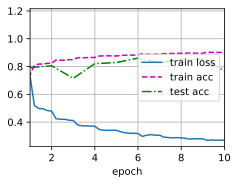

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Have a look at the **scale parameter gamma** and **the shift parameter beta** learned from the first batch normalization layer.

In [8]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.8362, 2.8104, 3.7959, 2.9052, 2.6722, 2.9533],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-2.9465,  3.0458,  2.3838, -1.4624,  1.6122, -0.5678],
        grad_fn=<ReshapeAliasBackward0>))

## Concise Implementation

Compared with the `BatchNorm` class,
which we just defined ourselves,
we can use the `BatchNorm` class defined in high-level APIs from the deep learning framework directly.
The code looks virtually identical
to our implementation above, except that we no longer need to provide additional arguments for it to get the dimensions right.

In [9]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.267, train acc 0.901, test acc 0.867
6188.3 examples/sec on cpu


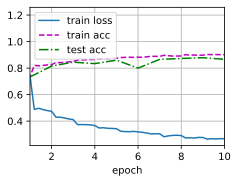

In [10]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Below, we [**use the same hyperparameters to train our model.**]
Note that as usual, the high-level API variant runs much faster
because its code has been compiled to C++ or CUDA
while our custom implementation must be interpreted by Python.